In [4]:
# загрузка необходимых библиотек
import os
import time
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as m
from catboost import CatBoostClassifier, Pool

# Datasets

In [5]:
# получение путей к файлам
tiff_files = []
directory = 'data/train'
for root, dirs, files in os.walk(directory, topdown = False):
   for file in files:
        if os.path.splitext(file)[1] == '.tiff':
            tiff_files.append(os.path.join(root, file))

In [6]:
# количество файлов
len(tiff_files)

21

In [7]:
# формирование тренировочного датасета
list_of_df = []
for file in tiff_files[:-1]:
    with rasterio.open(file) as src:
        df = pd.DataFrame(src.read(5).reshape(-1, 1))
        df.columns = ['target']
        for i in range(1, 5):
            df[f'band{i}'] = src.read(i).reshape(-1, 1)
            
        list_of_df.append(df)

df_train = list_of_df[0]
for df in list_of_df[1:-2]:
    df_train = pd.concat([df_train, df])
df_train.reset_index(drop=True, inplace=True)   

df_valid = list_of_df[-2]
df_valid.reset_index(drop=True, inplace=True)  

df_test = list_of_df[-1]
df_test.reset_index(drop=True, inplace=True)   

In [8]:
df_train.shape

(2490775, 5)

In [9]:
df_valid.shape

(302290, 5)

In [10]:
df_test.shape

(73953, 5)

In [11]:
X_train = df_train.drop(['target'], axis=1)
y_train = df_train['target']

X_valid = df_valid.drop(['target'], axis=1)
y_valid = df_valid['target']

X_test = df_test.drop(['target'], axis=1)
y_test = df_test['target']

# Model

In [12]:
train_pool = Pool(
        X_train, 
        y_train, 
    )
valid_pool = Pool(
        X_valid, 
        y_valid, 
    )

In [13]:
%%time
clf = CatBoostClassifier(random_state=42,
                         task_type='GPU',
                         learning_rate=0.01,
                         iterations=1000,
                         eval_metric='AUC'
                        )
clf.fit(train_pool, eval_set=valid_pool, verbose=200, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5615491	best: 0.5615491 (0)	total: 28.2ms	remaining: 28.2s
200:	test: 0.7503897	best: 0.7503897 (200)	total: 3.27s	remaining: 13s
400:	test: 0.7647472	best: 0.7673038 (335)	total: 6.49s	remaining: 9.7s
600:	test: 0.7690782	best: 0.7690782 (600)	total: 9.71s	remaining: 6.45s
800:	test: 0.7790238	best: 0.7790238 (800)	total: 12.9s	remaining: 3.22s
999:	test: 0.7889233	best: 0.7889233 (999)	total: 16.2s	remaining: 0us
bestTest = 0.7889232635
bestIteration = 999
CPU times: user 24.5 s, sys: 4.27 s, total: 28.8 s
Wall time: 17.3 s


In [16]:
clf.save_model("firemlmodel.json", format="json", export_parameters=None, pool=None)

In [13]:
print(f'ROC_AUC {m.roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1]):2.5f}')

ROC_AUC 0.78709


In [14]:
print(f'ROC_AUC {m.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]):2.5f}')

ROC_AUC 0.43815


# Predict

In [15]:
file = tiff_files[-1] # указать путь к тестовому файлу
with rasterio.open(file) as src:
        test_shape = (src.read(1).shape)
        df = pd.DataFrame(src.read(1).reshape(-1, 1))
        df.columns = ['band1']
        for i in range(2, 5):
            df[f'band{i}'] = src.read(i).reshape(-1, 1)
df

,band1,band2,band3,band4
0,16.0,19.0,21.0,32.0
1,9.0,11.0,17.0,26.0
2,8.0,10.0,15.0,23.0
3,7.0,9.0,13.0,20.0
4,6.0,8.0,11.0,18.0
...,...,...,...,...
1637787,33.0,38.0,48.0,67.0
1637788,29.0,34.0,42.0,62.0
1637789,21.0,26.0,36.0,57.0
1637790,18.0,23.0,31.0,52.0


In [32]:
res = clf.predict_proba(df)[:,1]
res

array([0.01505329, 0.16399266, 0.13576898, ..., 0.35053083, 0.3380039 ,
       0.22672751])

In [33]:
res = np.array([1 if i > 0.45 else 0 for i in res ]).reshape(test_shape) # порог сам придумал, с 0.5 только 6 точек показал :)
res # собствено предсказанный 5-й слой

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [25]:
test_shape, res.shape

((992, 1651), (992, 1651))

In [26]:
# визуализация изображения
def visualize_rgb_geotiff(file_path, r_band, g_band, b_band, ik_band, mask_band, photo_laer: str):
    try:
        with rasterio.open(file_path) as src:
            num_bands = src.count
            print(f"Number of bands: {num_bands}")
            red = src.read(r_band)  # B02 - Blue
            green = src.read(g_band)  # B03 - Green
            blue = src.read(b_band)  # B04 - Red
            ik = src.read(ik_band)
            mask = src.read(mask_band)

            if photo_laer == "full":
                photo = np.stack([red, green, blue], axis=-1)  # Отрисовка всего изображения
            elif photo_laer == "ik_laer":
                photo = np.stack([ik], axis=-1) # Отрисовка ИК-слоя изображения
            elif photo_laer == "mask_laer":
                photo = np.stack([mask], axis=-1)  # Отрисовка маски изображения
            photo = photo.astype(np.uint8)
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.imshow(photo)
            ax.axis('off')
            plt.show()
    except Exception as e:
        print(f'Ошибка: {e}')

## Оригинальная маска из 20 изображения

Number of bands: 5


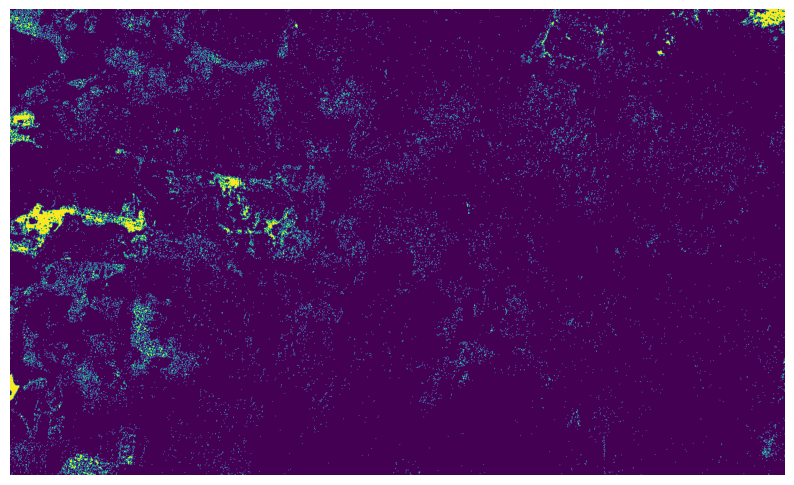

In [20]:
visualize_rgb_geotiff(tiff_files[-1], 1, 2, 3, 4, 5, "mask_laer")

## Предсказанная маска

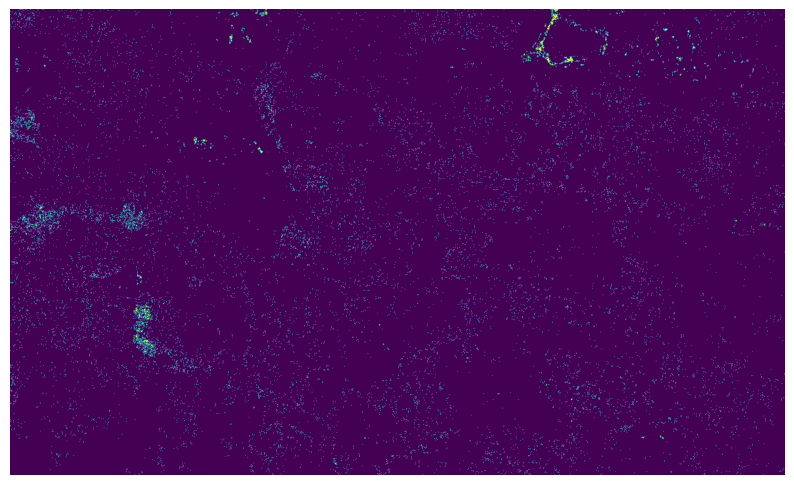

In [34]:
photo = np.stack([res], axis=-1)
photo = photo.astype(np.uint8)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(photo)
ax.axis('off')
plt.show()